# 指纹定位 Listwise

In [1]:
import os
import sys
import time
import random
import itertools

import pandas as pd
import numpy as np

import json
import lightgbm as lgb
from sklearn import datasets

In [2]:
def pre_process(response_str):
    try:
        # 1、pre_process data, get basic features
        str_list = []
        response_array = response_str[0: response_str.rindex('|')].split('|')
        if len(response_array) < 3:
            return None, None, None
        [gps_lat, gps_lng] = response_array[0].split('\t')  # gps location
        for index, r in enumerate(response_array, start=0):
            if r.strip() and len(response_array) != 1 and index != 0:
                str_list.append([float(f) for f in r.split('\t') if f.strip()])
        
        mat = np.mat(str_list); pre_process_df = pd.DataFrame(mat)
        
        # lat = pre_process_df[0]; lng = pre_process_df[1]  # cur location feature
        pre_process_df[2] = pre_process_df[2].astype('int')  # sample label
        pre_process_df[2] = pre_process_df[2].replace([0, 1, 2], [2, 1, 0])
        
        # 2、add more feature
        sample_num, feature_num = pre_process_df.shape
        wifi_total = pre_process_df[3] + pre_process_df[4]
        pre_process_df[feature_num] = pre_process_df[3] / wifi_total  # 增加特征(12th)
        pre_process_df[feature_num + 1] = pre_process_df[4] / wifi_total  # 增加特征(13th)
        return pre_process_df, gps_lat, gps_lng
    except Exception as e:
        print(e)
        sys.stderr.write('Exception:\t' + response_str + '\n')
        return None, None, None

In [3]:
def min_max_standardize(cur_df, feature_list, fix_factor=0.0001):
    feature_df = cur_df[feature_list]
    feature_df = (feature_df - feature_df.min()) / (feature_df.max() - feature_df.min() + fix_factor)
    cur_df[feature_list] = feature_df
    return cur_df


def z_score_standardize(cur_df, feature_list):
    feature_df = cur_df[feature_list]
    df_mean = feature_df.iloc[:, :].mean(axis=0)  # mean for column
    df_var = feature_df.iloc[:, :].var(axis=0)
    feature_df = (feature_df.iloc[:, :] - df_mean) / df_var
    feature_df = feature_df.fillna(0)  # 当某个特征都相同时，归一化出现Nan，用0补充
    cur_df[feature_list] = feature_df
    return cur_df

In [4]:
def count_lines_for_file(file_path):
    line_cnt = -1
    for line_cnt, line in enumerate(open(file_path, 'r')):
        pass
    line_cnt += 1
    return line_cnt

In [5]:
def create_listwise_data(cur_file_name, split_percent=1.0, standardize_type='min_max'):
    fetures_label_df = pd.DataFrame()
    real_gps_df = pd.DataFrame()
    
    cur_file_path = os.path.abspath(cur_file_name)
#     print('\t cur file name: %s, \n\t\t time:%s\n' % (cur_file_path, time.ctime()))

    file_line_cnt = count_lines_for_file(cur_file_path)
    line_index_list = random.sample(list(range(file_line_cnt)), np.max([1, int(file_line_cnt * split_percent)]))
    print('\t\t'+cur_file_name+'\tline numbers:', split_percent, file_line_cnt, len(line_index_list))

    with open(cur_file_path, 'r') as f:
        for line_index, line in enumerate(f.readlines(), start=0):
            if line_index % 1500 == 0:
                print('\t\t[cur file:' + cur_file_name + '] : ' + str(line_index))
            if line_index not in line_index_list:
                continue
                
            try:
                resquest_str = line.split('||')[0]
                response_str = line.split('||')[1]
            except Exception as e:
                print(e, cur_file_name, '\t', line_index)
                continue
            if len(response_str) < 30 or response_str[0].upper() == 'E':
                continue

            # 1.pre process data
            cur_processed_df, gps_lat, gps_lng = pre_process(response_str)  # lat,lng,label,feature(13)
            if not gps_lat:
                continue

            # 2.standardize
            standardize_feature_list = list(range(3, cur_processed_df.shape[1]))
            if standardize_type == 'z_score':
                cur_standardize_df = z_score_standardize(cur_processed_df, standardize_feature_list)
            if standardize_type == 'min_max':
                cur_standardize_df = min_max_standardize(cur_processed_df, standardize_feature_list)

            # 3.collect (cur_standardize_df.shape[1] = 20)
            cur_standardize_df['qid'] = line_index
            fetures_label_df = fetures_label_df.append(cur_standardize_df)
            real_gps_df = real_gps_df.append(pd.Series([gps_lat, gps_lng], name=line_index))
            
    fetures_label_df.index = list(range(len(fetures_label_df)))
    columnsName_list = ['lat', 'lng', 'label'] + list(range(13)) + ['qid']
    print(len(columnsName_list), fetures_label_df.shape)
    fetures_label_df.columns = columnsName_list
    
    real_gps_df.columns = ['real_lat', 'real_lng']
    return fetures_label_df, real_gps_df

In [52]:
def calc_distance(lng1, lat1, lng2, lat2):  # 经度1，纬度1，经度2，纬度2 （十进制度数)
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    lng1 = float(lng1); lat1 = float(lat1)
    lng2 = float(lng2); lat2 = float(lat2)
    from math import radians, cos, sin, asin, sqrt
    # 将十进制度数转化为弧度
    lng1, lat1, lng2, lat2 = map(radians, [lng1, lat1, lng2, lat2])

    # haversine公式
    dlon = lng2 - lng1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # 地球平均半径，单位为公里
    return c * r * 1000  # 单位是米

In [53]:
lat1=23.18366
lng1=113.264392
lat2=23.1828
lng2=113.2638

calc_distance(lng1, lat1, lng2, lat2)

113.16506457052637

In [7]:
fp_train_filePath = 'raw.fp_rank.train.data'

In [8]:
fetures_label_df, real_gps_df = create_listwise_data(fp_train_filePath)

		raw.fp_rank.train.data	line numbers: 1.0 100 100
		[cur file:raw.fp_rank.train.data] : 0
list index out of range raw.fp_rank.train.data 	 77
17 (2287, 17)


In [9]:
real_gps_df.head(3)

,real_lat,real_lng
0,30.643930,103.802525
1,31.259990,119.836123
2,37.134355,114.673698


In [10]:
print(fetures_label_df.shape)
fetures_label_df.head(3)

(2287, 17)


,lat,lng,label,0,1,2,3,4,5,6,7,8,9,10,11,12,qid
0,30.6434,103.8011,0,0.999991,0.0,0.332994,0.999667,0.997009,0.997009,0.032764,0.999895,0.998446,0.497499,0.518354,0.999727,0.0,0
1,30.6436,103.8015,0,0.999991,0.0,0.369994,0.999667,0.997009,0.997009,0.081713,0.985162,0.998446,0.658253,0.672437,0.999727,0.0,0
2,30.6436,103.8026,1,0.999991,0.0,0.702988,0.999667,0.997009,0.997009,0.049104,0.023905,0.119003,0.764981,0.699733,0.999727,0.0,0


In [11]:
print(fetures_label_df['qid'].value_counts().shape)
fetures_label_df['qid'].value_counts()[99]

(99,)


36

In [12]:
fetures_label_df.groupby(by=['qid'])[0].agg(np.size).head(3)

qid
0    12.0
1    12.0
2    10.0
Name: 0, dtype: float64

## 一、生成  listwise  数据

In [13]:
feature_columns_list = list(range(11))
label_columns_list = 'label'

gps_columns_list = ['lat', 'lng']
qid_columns_list = 'qid'

### train data

In [14]:
train_x = fetures_label_df[feature_columns_list]
train_y = fetures_label_df[label_columns_list]

train_gps = fetures_label_df[gps_columns_list]
train_qid = fetures_label_df[qid_columns_list].value_counts().sort_index()

In [15]:
fp_train_libsvm_filePath = './fp_rank.train.libsvm'
fp_train_gps_filePath = './fp_rank_gps.train.data'
fp_train_qid_filePath = './fp_rank_qid.train.data'

In [16]:
train_x = fetures_label_df[feature_columns_list]
train_y = fetures_label_df[label_columns_list]

train_gps = fetures_label_df[gps_columns_list]
train_qid = fetures_label_df[qid_columns_list].value_counts().sort_index()

In [17]:
datasets.dump_svmlight_file(train_x.values, train_y.values.reshape(len(train_y)), fp_train_libsvm_filePath)
train_gps.to_csv(fp_train_gps_filePath)
train_qid.to_csv(fp_train_qid_filePath)

In [55]:
print(train_qid.shape)
print(type(train_qid), type(train_qid.values))
print(len(train_qid))
train_qid.values

(99,)
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
99


array([12, 12, 10, 34, 29, 32,  9, 10,  4,  7, 35, 15, 42, 28, 29,  6, 11,
        5, 11, 38, 30,  9,  7, 46,  9, 29, 45, 29, 15, 33, 12, 43, 29, 33,
       10,  6, 39, 35, 38, 34, 41, 40, 31,  6, 31, 40, 34, 35, 35, 38, 32,
       24, 32, 35,  8, 34,  7, 26,  7,  3, 15,  9, 39, 21, 36,  9, 33, 37,
       34,  4, 12,  3,  8,  3, 10, 35, 32, 21, 37, 33, 33, 28, 25, 22,  3,
        7, 45, 47, 29, 27,  7,  5,  2, 34,  6,  9, 30, 12, 36],
      dtype=int64)

In [19]:
test = pd.read_csv(fp_train_qid_filePath, header=-1)
print(type(test))
test[1].values

<class 'pandas.core.frame.DataFrame'>


array([12, 12, 10, 34, 29, 32,  9, 10,  4,  7, 35, 15, 42, 28, 29,  6, 11,
        5, 11, 38, 30,  9,  7, 46,  9, 29, 45, 29, 15, 33, 12, 43, 29, 33,
       10,  6, 39, 35, 38, 34, 41, 40, 31,  6, 31, 40, 34, 35, 35, 38, 32,
       24, 32, 35,  8, 34,  7, 26,  7,  3, 15,  9, 39, 21, 36,  9, 33, 37,
       34,  4, 12,  3,  8,  3, 10, 35, 32, 21, 37, 33, 33, 28, 25, 22,  3,
        7, 45, 47, 29, 27,  7,  5,  2, 34,  6,  9, 30, 12, 36],
      dtype=int64)

## 二、开始训练

In [20]:
# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'lambdarank',
#     'metric': 'ndcg',
#     'metric': 'map',
    'metric': ['ndcg', 'map'],
    'metric_freq' : 10,
    'ndcg_eval_at' : '1,3,5,',
#     'ndcg_eval_at' : '3',
    'is_training_metric' : True,
    'max_bin' : 255,
    'num_leaves': 31,
#     'num_trees' : 100,
#     'learning_rate': 0.1,
    'learning_rate': 0.05,
    'tree_learner': 'serial',
    'min_data_in_leaf' :50,
    'min_sum_hessian_in_leaf': 50,
    'is_enable_sparse': True,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 10,
    'verbose_eval ': 10,
}

In [21]:
fp_train = lgb.Dataset(fp_train_libsvm_filePath)
fp_train_group = train_qid.values
fp_train.set_group(fp_train_group)

fp_test = lgb.Dataset(fp_train_libsvm_filePath)
fp_test_group = train_qid.values
fp_test.set_group(fp_test_group)

print(len(fp_train_group), len(fp_test_group))
print(sum(fp_train_group), sum(fp_test_group))

99 99
2287 2287


In [22]:
gbm = lgb.train(
    params,
    fp_train,
    num_boost_round=10000,
    early_stopping_rounds=1000,
    valid_sets=[fp_train],
)

[1]	training's map@1: 0.979798	training's map@3: 0.98092	training's map@5: 0.974916	training's ndcg@1: 0.878788	training's ndcg@3: 0.891758	training's ndcg@5: 0.900477
Training until validation scores don't improve for 1000 rounds.
[2]	training's map@1: 0.979798	training's map@3: 0.974186	training's map@5: 0.969057	training's ndcg@1: 0.892256	training's ndcg@3: 0.892631	training's ndcg@5: 0.908598
[3]	training's map@1: 0.979798	training's map@3: 0.976431	training's map@5: 0.975253	training's ndcg@1: 0.89899	training's ndcg@3: 0.906269	training's ndcg@5: 0.916867
[4]	training's map@1: 0.979798	training's map@3: 0.98092	training's map@5: 0.976431	training's ndcg@1: 0.912458	training's ndcg@3: 0.912374	training's ndcg@5: 0.921455
[5]	training's map@1: 0.979798	training's map@3: 0.984287	training's map@5: 0.977744	training's ndcg@1: 0.925926	training's ndcg@3: 0.92223	training's ndcg@5: 0.924836
[6]	training's map@1: 0.979798	training's map@3: 0.984287	training's map@5: 0.981785	training's

[103]	training's map@1: 1	training's map@3: 0.992144	training's map@5: 0.987407	training's ndcg@1: 0.979798	training's ndcg@3: 0.96848	training's ndcg@5: 0.968336
[104]	training's map@1: 1	training's map@3: 0.992144	training's map@5: 0.987407	training's ndcg@1: 0.979798	training's ndcg@3: 0.97006	training's ndcg@5: 0.968495
[105]	training's map@1: 1	training's map@3: 0.992144	training's map@5: 0.987407	training's ndcg@1: 0.979798	training's ndcg@3: 0.97006	training's ndcg@5: 0.970262
[106]	training's map@1: 1	training's map@3: 0.992144	training's map@5: 0.985387	training's ndcg@1: 0.979798	training's ndcg@3: 0.97006	training's ndcg@5: 0.969668
[107]	training's map@1: 1	training's map@3: 0.992144	training's map@5: 0.985387	training's ndcg@1: 0.979798	training's ndcg@3: 0.97006	training's ndcg@5: 0.969768
[108]	training's map@1: 1	training's map@3: 0.992144	training's map@5: 0.985387	training's ndcg@1: 0.979798	training's ndcg@3: 0.97006	training's ndcg@5: 0.968884
[109]	training's map@1

[209]	training's map@1: 1	training's map@3: 0.988777	training's map@5: 0.990202	training's ndcg@1: 0.993266	training's ndcg@3: 0.974616	training's ndcg@5: 0.977209
[210]	training's map@1: 1	training's map@3: 0.988777	training's map@5: 0.990202	training's ndcg@1: 0.993266	training's ndcg@3: 0.974616	training's ndcg@5: 0.977209
[211]	training's map@1: 1	training's map@3: 0.988777	training's map@5: 0.990202	training's ndcg@1: 0.993266	training's ndcg@3: 0.974616	training's ndcg@5: 0.977209
[212]	training's map@1: 1	training's map@3: 0.988777	training's map@5: 0.990202	training's ndcg@1: 0.993266	training's ndcg@3: 0.974616	training's ndcg@5: 0.977209
[213]	training's map@1: 1	training's map@3: 0.988777	training's map@5: 0.990202	training's ndcg@1: 0.993266	training's ndcg@3: 0.974616	training's ndcg@5: 0.976326
[214]	training's map@1: 1	training's map@3: 0.988777	training's map@5: 0.990202	training's ndcg@1: 0.993266	training's ndcg@3: 0.974616	training's ndcg@5: 0.976326
[215]	training's

[348]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98069	training's ndcg@5: 0.98422
[349]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98069	training's ndcg@5: 0.98422
[350]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98069	training's ndcg@5: 0.98422
[351]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98069	training's ndcg@5: 0.98422
[352]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98069	training's ndcg@5: 0.98422
[353]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98069	training's ndcg@5: 0.98422
[354]	training's map@1: 1	tr

[506]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98385	training's ndcg@5: 0.986859
[507]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98385	training's ndcg@5: 0.986859
[508]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98385	training's ndcg@5: 0.986859
[509]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98385	training's ndcg@5: 0.986859
[510]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98385	training's ndcg@5: 0.986859
[511]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98385	training's ndcg@5: 0.986859
[512]	training's map@1

[710]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98385	training's ndcg@5: 0.987742
[711]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98385	training's ndcg@5: 0.988626
[712]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98385	training's ndcg@5: 0.988626
[713]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98385	training's ndcg@5: 0.988626
[714]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98385	training's ndcg@5: 0.988626
[715]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98385	training's ndcg@5: 0.988626
[716]	training's map@1

[866]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98543	training's ndcg@5: 0.990904
[867]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98543	training's ndcg@5: 0.990904
[868]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98543	training's ndcg@5: 0.990904
[869]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98543	training's ndcg@5: 0.990904
[870]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98543	training's ndcg@5: 0.990904
[871]	training's map@1: 1	training's map@3: 0.993266	training's map@5: 0.991717	training's ndcg@1: 0.993266	training's ndcg@3: 0.98543	training's ndcg@5: 0.990904
[872]	training's map@1

In [23]:
preds = gbm.predict(fp_test.data)

In [24]:
len(preds), fp_test.label

(2287, None)

In [23]:
gbm.best_score

defaultdict(dict,
            {'training': {'map@1': 1.0,
              'map@3': 0.9876543209876543,
              'map@5': 0.9797643097643098,
              'ndcg@1': 0.9663299663299663,
              'ndcg@3': 0.9516071817863215,
              'ndcg@5': 0.9509523431112329}})

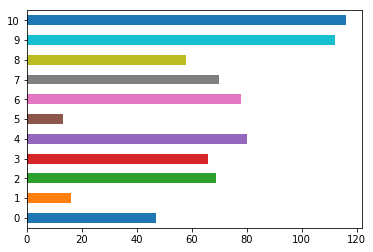

In [24]:
feature_imp = gbm.feature_importance()
feature_imp_series = pd.Series(feature_imp)

%matplotlib inline
feature_imp_series.plot(kind='barh')

In [106]:
preds_series = pd.Series(preds)

fetures_label_df['pred'] = preds_series
print(fetures_label_df.shape)
fetures_label_df.head(3)

(2287, 18)


,lat,lng,label,0,1,2,3,4,5,6,7,8,9,10,11,12,qid,pred
0,30.6434,103.8011,0,0.999991,0.0,0.332994,0.999667,0.997009,0.997009,0.032764,0.999895,0.998446,0.497499,0.518354,0.999727,0.0,0,-0.384362
1,30.6436,103.8015,0,0.999991,0.0,0.369994,0.999667,0.997009,0.997009,0.081713,0.985162,0.998446,0.658253,0.672437,0.999727,0.0,0,-0.296336
2,30.6436,103.8026,1,0.999991,0.0,0.702988,0.999667,0.997009,0.997009,0.049104,0.023905,0.119003,0.764981,0.699733,0.999727,0.0,0,-0.214925


In [26]:
print(real_gps_df.shape)
real_gps_df.tail(3)

(99, 2)


,real_lat,real_lng
97,31.209918,121.419305
98,32.316303,119.874845
99,31.286028,121.521222


In [27]:
top_grid_threshold = 3

result_df = pd.DataFrame()
for cur_group in fetures_label_df.groupby(by=['qid']):
    (group_index, cur_df) = cur_group
    cur_qid = cur_df['qid'].values[0]
    cur_sorted_df = cur_df.sort_values(by=['pred'], ascending=False)
    cur_threshold = min(top_grid_threshold, len(cur_sorted_df))
    pred_lat, pred_lng = cur_sorted_df.loc[:, ['lat', 'lng']].head(cur_threshold).mean().values
    real_lat, real_lng = real_gps_df.loc[cur_qid, ['real_lat', 'real_lng']].values
    dist = calc_distance(pred_lng, pred_lat, real_lng, real_lat)
    result_df = result_df.append(pd.Series([cur_qid, dist, pred_lat, pred_lng, real_lat, real_lng]), ignore_index=True)
print(result_df.shape)
result_df.columns = ['qid', 'dist', 'pred_lat', 'pred_lng', 'real_lat', 'real_lng']

(99, 6)


In [28]:
result_df = result_df.sort_values(by=['dist'], ascending=True)
result_df.head(3)

,qid,dist,pred_lat,pred_lng,real_lat,real_lng
83,84.0,0.438911,31.230600,121.666100,31.230603,121.666097
0,0.0,0.879173,30.643933,103.802533,30.643930,103.802525
3,3.0,1.387819,23.137033,113.310367,23.137031,113.310380


In [29]:
cep_90_len = int(len(result_df)*0.9)

accu = result_df['dist'].mean()
cep90 = result_df['dist'].head(cep_90_len).mean()

print(accu, cep90)

12.090826690056993 9.465399378018144


## 三、开始测试

In [40]:
from sklearn.externals import joblib

In [41]:
def evaluate_in_one_query(cur_file_path, rank_listwise_model, cur_model_file_path, standardize_type='min_max'):
    
    dist_list = []
    with open(cur_file_path, 'r') as f:
        for line_index, line in enumerate(f.readlines(), start=0):
            try:
                resquest_str = line.split('||')[0]
                response_str = line.split('||')[1]
            except Exception as e:
                print(e, line_index)
                continue

            if len(response_str) < 30 or response_str[0].upper() == 'E':
                continue
            if line_index % 30 == 0:
                print('\t[cur file:' + cur_file_path + '] : ' + str(line_index))
    
            if line_index != 0:
                continue
                
            # 1.pre process data
            t1 = time.time()
            cur_processed_df, gps_lat, gps_lng = pre_process(response_str)  # lat,lng,label,feature(13)
            if not gps_lat:
                continue
            t2 = time.time()

            # 2.standardize
            standardize_feature_list = list(range(3, cur_processed_df.shape[1]))  # select feature to standardize
            if standardize_type == 'z_score':
                cur_standardize_df = z_score_standardize(cur_processed_df, standardize_feature_list)
            if standardize_type == 'min_max':
                cur_standardize_df = min_max_standardize(cur_processed_df, standardize_feature_list)
            t3 = time.time()    
            
            # 3.generate pairwise data
            cur_pairwise_df = gen_pairwise_df_with_macindex(cur_standardize_df)
            t4 = time.time()
            
            # 4.evaluate
            if cur_pairwise_df.shape[0] == 0:
                continue
            online_dist, online_top_df = evaluate_with_11th_score(gps_lat, gps_lng, response_str)
            t5 = time.time()
            
            model_dist, model_top_df = evaluate_with_model(gps_lat, gps_lng, cur_model_file_path, cur_pairwise_df)
            t6 = time.time()
            
            listwise_dist, listwise_top_df = evaluate_by_listwise(gps_lat, gps_lng, gbm, cur_standardize_df)
            t7 = time.time()
            
            print('%4d | %8.2f | %8.2f | %8.2f | %8.2f | %8.2f |%s' % 
                  (line_index, float(gps_lat), float(gps_lng), online_dist, model_dist, listwise_dist, cur_processed_df.shape))

            print('%4d | pre:%4f | stand:%4f | pair:%4f | score:%4f | pairwise:%4f | listwise:%4f' % 
                  (line_index, t2-t1, t3-t2, t4-t3, t5-t4, t6-t5, t7-t6))
            print()
            

In [47]:
top_grid_threshold = 3

def evaluate_by_listwise(real_lat, real_lng, rank_listwise_model, cur_standardize_df):
    used_feature_columns = list(range(3, 14))
    true_gps_columns = list(range(0, 3))
    x_test = cur_standardize_df.loc[:, used_feature_columns].values
    result_df = cur_standardize_df.loc[:, true_gps_columns]
    print(type(x_test))
    fp_test = lgb.Dataset(data=x_test)
    print(type(fp_test))
    y_pred = rank_listwise_model.predict(fp_test.data)
    result_df['pred'] = pd.Series(y_pred, name='pred')
    result_df = result_df.sort_values(by='pred', ascending=False)
#     print(result_df)
    cur_threshold = min(top_grid_threshold, len(result_df))
    pred_lat, pred_lng = result_df.loc[:, [0, 1]].head(cur_threshold).mean().values
    dist = calc_distance(pred_lng, pred_lat, real_lng, real_lat)
    return dist, result_df.loc[:, [0, 1]]


def evaluate_with_11th_score(gps_lat, gps_lng, fp_str, score_index=13):
    str_list = []
    fp_str_array = fp_str[0: fp_str.rindex('|')].split('|')
    for index, r in enumerate(fp_str_array, start=0):
        if r.strip() and len(fp_str_array) != 1 and index != 0:
            str_list.append([float(f) for f in r.split('\t') if f.strip()])
    mat = np.mat(str_list); df = pd.DataFrame(mat)

    sorted_df = df.sort_values(by=score_index, ascending=False)

    top3_len = np.min([len(sorted_df), 3]) # this use top3
    top3_sorted_df = sorted_df.head(top3_len)

    [mean_lat, mean_lng] = top3_sorted_df.mean().tolist()[0: 2]
    online_dist = calc_distance(mean_lng, mean_lat, gps_lng, gps_lat)
    return online_dist, top3_sorted_df.iloc[:, [0, 1]]


def evaluate_with_model(gps_lat, gps_lng, cur_model_file_path, cur_pairwise_df):
    feature_dict = {
        'combine_10': list(range(0, 18)),  # select features
        'combine_11': list(range(0, 20)),  # select features
        'combine_13': list(range(0, 22)),
    }

    feature_name = 'combine_11'
    feature_list = feature_dict[feature_name]
    [X, Y, label_1th, label_2th, grid_index_1th, grid_index_2th, loc_df] = extract_pairwise_data_by_feature_with_macindex(cur_pairwise_df, feature_name, feature_list, split_percent=0)
    try:
        if 'xgboost' in cur_model_file_path:
            cur_model = xgb.Booster(model_file=cur_model_file_path)
            y_pred = cur_model.predict(xgb.DMatrix(X.values))
        else:
            cur_model = joblib.load(cur_model_file_path)
            y_pred = cur_model.predict(X)
    except:
        print('error model')

    # matched grid score dict
    grid_score_dict = {}
    for pair_index in range(len(y_pred)):
        if grid_index_1th[pair_index] not in grid_score_dict.keys():
            grid_score_dict[grid_index_1th[pair_index]] = 0
        if grid_index_2th[pair_index] not in grid_score_dict.keys():
            grid_score_dict[grid_index_2th[pair_index]] = 0
        if y_pred[pair_index]:
            grid_score_dict[grid_index_1th[pair_index]] += 1
        else:
            grid_score_dict[grid_index_2th[pair_index]] += 1

    # matched grid score rank --> top3
    grid_score_dict = sorted(grid_score_dict.items(), key=lambda d: d[1], reverse=True)
    top3_len = np.min([len(grid_score_dict), 3])  # this use top3
    top3_grid_index_list = [int(item[0]) for item in grid_score_dict[0: top3_len]]

    # grid location dict
    grid_loc_dict = {}
    for pair_index in range(len(grid_index_1th)):
        if grid_index_1th[pair_index] not in grid_loc_dict.keys():
            grid1_loc = loc_df.ix[pair_index, [3, 4]].tolist()
            grid_loc_dict[grid_index_1th[pair_index]] = grid1_loc
        if grid_index_2th[pair_index] not in grid_loc_dict.keys():
            grid2_loc = loc_df.ix[pair_index, [5, 6]].tolist()
            grid_loc_dict[grid_index_2th[pair_index]] = grid2_loc
            
    # top3 mean location
    mean_loc_df = pd.DataFrame()
    for top_grid_index in top3_grid_index_list:
        mean_loc_df = mean_loc_df.append(pd.Series(grid_loc_dict[top_grid_index]), ignore_index=True)
    [mean_lat, mean_lng] = mean_loc_df.mean().tolist()

    model_dist = calc_distance(mean_lng, mean_lat, gps_lng, gps_lat)
    return model_dist, mean_loc_df     


In [48]:
def gen_pairwise_df_with_macindex(data_df):
    data_df.index = list(range(data_df.shape[0]))
    data_df.columns = list(range(data_df.shape[1]))

    # pairwise df
    pairwise_index_list = []
    for index in itertools.combinations(list(range(data_df.shape[0])), 2):
        pairwise_index_list.append([index[0], index[1]])
    pairwise_index_list = np.array(pairwise_index_list)
    col0 = data_df.iloc[pairwise_index_list[:, 0]]; col0.index = range(len(col0))
    col1 = data_df.iloc[pairwise_index_list[:, 1]]; col1.index = range(len(col1))
    pairwise_df = pd.concat([pd.DataFrame(pairwise_index_list), col0, col1], axis=1)

    # feature compute (grid_index1, grid_index2, lat_1, lng_1, label1, ... , lat_2, lng_2, label2)
    pairwise_df.index = list(range(pairwise_df.shape[0]))
    pairwise_df.columns = list(range(pairwise_df.shape[1]))
    feature_num = int((pairwise_df.shape[1]-2) / 2)
    raw_feature = pairwise_df.iloc[:, [4, feature_num + 4, 2, 3, feature_num + 2, feature_num + 3, 0, 1]]
    
    pairwise_label = (pairwise_df[4] < pairwise_df[feature_num + 4]).astype(int)
    feature_1 = pairwise_df.iloc[:, list(range(5, feature_num + 2))].astype(float)
    feature_2 = pairwise_df.iloc[:, list(range(feature_num + 5, feature_num * 2 + 2))].astype(float)
    feature_1.columns = list(range(feature_1.shape[1]))
    feature_2.columns = list(range(feature_2.shape[1]))
    compute_feature = feature_1 - feature_2

    pairwise_feature_df = pd.concat([pairwise_label, raw_feature, compute_feature], axis=1)
    pairwise_feature_df.columns = list(range(pairwise_feature_df.shape[1]))
    return pairwise_feature_df


# -------------------------------------------------------------------------------------------------------


def extract_pairwise_data_by_feature_with_macindex(cur_pairwise_df, feature_name, feature_list, split_percent=0):
    cur_feat_pairwise_df = cur_pairwise_df.iloc[:, feature_list]
    # print(feature_name, cur_feat_pairwise_df.shape, '\n')

    cur_feat_pairwise_df.columns = list(range(cur_feat_pairwise_df.shape[1]))
    train_df, test_df = random_split_trainDF_testDF_from_df(cur_feat_pairwise_df, split_percent)
    # print(feature_name, train_df.shape, test_df.shape, '\n')

    # train data
    X, Y, label_1th, label_2th, mac_index_1th, mac_index_2th, loc_df = extract_x_y_label_from_df_with_macindex(train_df)
    return [X, Y, label_1th, label_2th, mac_index_1th, mac_index_2th, loc_df]


def extract_x_y_label_from_df_with_macindex(data_df):
    '''
        contains mac_index
    '''
    sample_num, feature_num = data_df.shape
    data_df.columns = list(range(feature_num))
    y = data_df[0]
    label_1 = data_df[1]
    label_2 = data_df[2]
    loc_df = data_df.ix[:, 3:6]
    mac_index_1 = data_df[7]; mac_index_2 = data_df[8]
    X = data_df.iloc[:, 9:feature_num]
    return X, y, label_1, label_2, mac_index_1, mac_index_2, loc_df

def random_split_trainDF_testDF_from_df(all_data_df, split_percent):
    # 均匀分布采样，已经引入样本数量权重
    test_index_list = random.sample(list(all_data_df.index), int(len(all_data_df) * split_percent))
    train_index_list = list(set(all_data_df.index).difference(test_index_list))
    train_df = all_data_df.iloc[train_index_list]
    train_df.index = list(range(len(train_df)))
    test_df = all_data_df.iloc[test_index_list]
    test_df.index = list(range(len(test_df)))
    return train_df, test_df


In [49]:
fp_train = lgb.Dataset(fp_train_libsvm_filePath)
fp_train_group = train_qid.values
fp_train.set_group(fp_train_group)

fp_test = lgb.Dataset(fp_train_libsvm_filePath)
fp_test_group = train_qid.values
fp_test.set_group(fp_test_group)

print(len(fp_train_group), len(fp_test_group))
print(sum(fp_train_group), sum(fp_test_group))

99 99
2287 2287


In [50]:
fp_test_filePath = 'raw.fp_rank.test.data'
rank_pairwise_model_path = 'fp_model@logistic.standardize_pair.m'

In [51]:
evaluate_in_one_query(fp_test_filePath, gbm, rank_pairwise_model_path)

	[cur file:raw.fp_rank.test.data] : 0


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:57: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Program Files\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:80: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional index

<class 'numpy.ndarray'>
<class 'lightgbm.basic.Dataset'>
   0 |    30.28 |   120.16 |     8.93 |     8.93 |     8.93 |(133, 16)
   0 | pre:0.004000 | stand:0.003000 | pair:0.016002 | score:0.002000 | pairwise:0.370037 | listwise:0.006001

	[cur file:raw.fp_rank.test.data] : 30
	[cur file:raw.fp_rank.test.data] : 60
	[cur file:raw.fp_rank.test.data] : 90
